# Семинар. Гауссовские процессы (GP) с GPyTorch

На семинаре мы будем использовать библиотеку [GPyTorch](https://gpytorch.ai/) для моделирования GP.

In [47]:
#!pip install gpytorch

## Решение задачи регрессии с использованием гауссовских процессов
Дан набор данных $\left (X, \mathbf{y} \right ) = \left \{ (x_i, y_i), x_i \in \mathbb{R}^d, y_i \in \mathbb{R} \right \}_{i = 1}^N$.  

Мы считаем, что:
$$
y = f(x) + \varepsilon,
$$
где $f(x)$ - гауссовский процесс и $\varepsilon \sim \mathcal{N}(0, \sigma_\varepsilon^2)$ - гауссовский шум.

Апостериорное распределение наблюдения $y^*$ в точке $x^*$ является гауссовским:
$$
y_* | X, \mathbf{y}, x_* \sim \mathcal{N}(m(x_*), \sigma(x_*)),
$$
с средним и дисперсией, вычисляемыми по формулам:
$$
m(x_*) = \mathbf{k}^T \mathbf{K}_y^{-1} \mathbf{y} = \sum_{i = 1}^N \alpha_i k(x_*, x_i),
$$
$$
\sigma^2(x_*) = k(x_*, x_*) + \sigma_\varepsilon^2 - \mathbf{k}^T\mathbf{K}_y^{-1}\mathbf{k},
$$
где
$$
\mathbf{k} = \left ( k(x_*, x_1), \ldots, k(x_*, x_N) \right )^T
$$
$$
\mathbf{K}_y = \|k(x_i, x_j)\|_{i, j = 1}^N + \sigma_\varepsilon^2 \mathbf{I}
$$

## GPyTorch регрессия
Мы будем моделировать функцию:
$$
\begin{align}
y &= \sin(2\pi x) + \varepsilon \\
  \varepsilon &\sim \mathcal{N}(0, 0.04) 
\end{align}
$$

с 100 обучающими, и 51 тестовыми примерами.


In [1]:
import math
import torch
import numpy as np
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# Training data is 100 points in [0,1] inclusive regularly spaced
train_x = torch.linspace(0, 1, 100)
# True function is sin(2*pi*x) with Gaussian noise
train_y = torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * math.sqrt(
    0.04
)

### Определение модели

Для получения GP модели нужно сконструировать следующие GPyTorch объекты:

1. **GP Model** (`gpytorch.models.ExactGP`) -  Имеет дело с предсказаниями.
1. **Likelihood** (`gpytorch.likelihoods.GaussianLikelihood`) - Самая распостраненная функция правдоподобия.
1. **Mean** - Опредленяет априорную функцию среднего.
1. **Kernel** - Определяет ядро для получения матрицы ковариации
1. **MultivariateNormal** Distribution (`gpytorch.distributions.MultivariateNormal`) - Объект, использующийся для определения многомерного нормального распределения
  


In [3]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, covar_module):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = covar_module

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

### Режимы модели

Как и в большинстве PyTorch модулей, `ExactGP` имеет `.train()` и `.eval()` режимы.
- `.train()` режим для оптимизации гиперпараметров.
- `.eval()` для вычисления апостериорного распределения.

### Обучение модели

В следующей клетке максимизируется правдоподобие данных для обучения гиперпараметров гауссовского процесса



In [4]:
def train_model(model, likelihood, train_x, train_y, training_iter=50, verbose=False):
    # Find optimal model hyperparameters
    model.train()
    likelihood.train()

    # Use the adam optimizer
    optimizer = torch.optim.Adam(
        model.parameters(), lr=0.1
    )  # Includes GaussianLikelihood parameters

    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    for i in range(training_iter):
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Output from model
        output = model(train_x)
        # Calc loss and backprop gradients
        loss = -mll(output, train_y)
        loss.backward()
        if verbose:
            print(
                "Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f"
                % (
                    i + 1,
                    training_iter,
                    loss.item(),
                    model.covar_module.base_kernel.lengthscale.item(),
                    model.likelihood.noise.item(),
                )
            )
        optimizer.step()

In [6]:
# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
model = ExactGPModel(train_x, train_y, likelihood, covar_module)
train_model(model, likelihood, train_x, train_y, training_iter=50, verbose=True)

Iter 1/50 - Loss: 0.937   lengthscale: 0.693   noise: 0.693
Iter 2/50 - Loss: 0.906   lengthscale: 0.644   noise: 0.644
Iter 3/50 - Loss: 0.872   lengthscale: 0.598   noise: 0.598
Iter 4/50 - Loss: 0.835   lengthscale: 0.555   noise: 0.554
Iter 5/50 - Loss: 0.794   lengthscale: 0.514   noise: 0.513
Iter 6/50 - Loss: 0.748   lengthscale: 0.475   noise: 0.474
Iter 7/50 - Loss: 0.698   lengthscale: 0.439   noise: 0.437
Iter 8/50 - Loss: 0.648   lengthscale: 0.404   noise: 0.402
Iter 9/50 - Loss: 0.600   lengthscale: 0.372   noise: 0.370
Iter 10/50 - Loss: 0.556   lengthscale: 0.342   noise: 0.339
Iter 11/50 - Loss: 0.516   lengthscale: 0.315   noise: 0.311
Iter 12/50 - Loss: 0.480   lengthscale: 0.292   noise: 0.284
Iter 13/50 - Loss: 0.446   lengthscale: 0.272   noise: 0.260
Iter 14/50 - Loss: 0.413   lengthscale: 0.256   noise: 0.237
Iter 15/50 - Loss: 0.381   lengthscale: 0.243   noise: 0.216
Iter 16/50 - Loss: 0.349   lengthscale: 0.233   noise: 0.197
Iter 17/50 - Loss: 0.318   length

### Предсказания с помощью модели

В следущих клетках мы получим предсказания гауссовского процесса в новых точках. Чтобы это сделать нужно перевести модель и likelihood в режим eval. и вызвать оба модуля на тестовых данных.

В режиме eval GP model возвращает `MultivariateNormal`, содержащий апостериорные среднее и дисперсии.

Если мы обозначим (`test_x`) как `x*`, истинное значение `y*`, тогда `model(test_x)` возвращает апостерирное распределение на значении функции `p(f* | x*, X, y)`, где `X, y` обучающие данные. 

Напротив, `likelihood(model(test_x))` даёт нам апостериорное предиктивное распределение `p(y* | x*, X, y)`, которое является распределением на целевое значение $y$, которое мы хотим предсказать.

Получение предиктивных дисперсии и среднего, и семплирование GP функций в новых тестовых точках может быть выполнено с помощью следующейго кода:

```python
f_preds = model(test_x)
y_preds = likelihood(model(test_x))

f_mean = f_preds.mean
f_var = f_preds.variance
f_covar = f_preds.covariance_matrix
f_samples = f_preds.sample(sample_shape=torch.Size(1000,))
```


In [7]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0, 1, 51)
    observed_pred = likelihood(model(test_x))

### Визуализация предсказаний


In [8]:
def plot_model(observed_pred, train_x, train_y, test_x):
    with torch.no_grad():
        # Initialize plot
        f, ax = plt.subplots(1, 1, figsize=(8, 6))

        # Get upper and lower confidence bounds
        lower, upper = observed_pred.confidence_region()
        # Plot training data as black stars
        ax.plot(train_x.numpy(), train_y.numpy(), ".")
        # Plot predictive means as blue line
        ax.plot(test_x.numpy(), observed_pred.mean.numpy())
        # Shade between the lower and upper confidence bounds
        ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
        ax.legend(["Observed Data", "Mean", "Confidence", "True"])
        return f

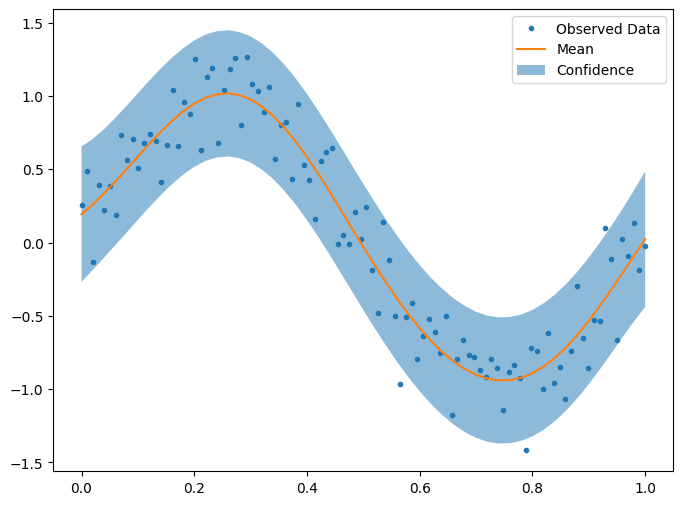

In [9]:
f = plot_model(observed_pred, train_x, train_y, test_x)

## Практический пример

Построение GP модели числа пассажиров самолётов.

In [10]:
#!wget https://github.com/adasegroup/ML2020_seminars/raw/master/seminar11/data/airline.npz

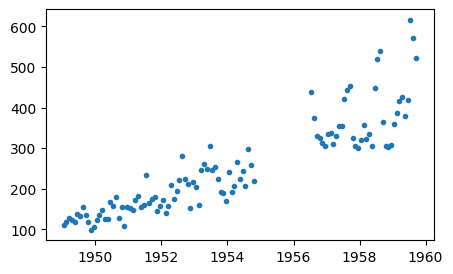

In [17]:
# load data
data = np.load("airline.npz")

X = data["X"][:, 0]
y = data["y"][:, 0]

train_indices = list(range(70)) + list(range(90, 129))
test_indices = range(70, 90)
X_train = X[train_indices]
y_train = y[train_indices]

# process data
# your code here
mean_x = np.mean(X_train)
std_x = np.std(X_train)

mean_y = np.mean(y_train)
std_y = np.std(y_train)


train_x = (torch.tensor(X_train, dtype=torch.float32) - mean_x) / std_x
train_y = (torch.tensor(y_train, dtype=torch.float32) - mean_y) / std_y
test_x = (torch.linspace(1948, 1964, 400, dtype=torch.float32) - mean_x) / std_x

plt.figure(figsize=(5, 3))
plt.plot(X_train, y_train, ".")
plt.show()

### RBF ядро

In [18]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
covar_module = gpytorch.kernels.RBFKernel()
model = ExactGPModel(train_x, train_y, likelihood, covar_module)
train_model(model, likelihood, train_x, train_y, training_iter=50)

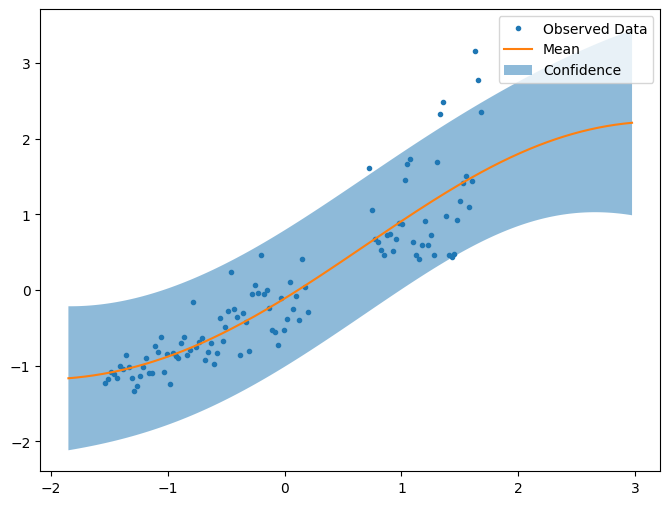

In [19]:
model.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(test_x))

f = plot_model(observed_pred, train_x, train_y, test_x)

### Сложное ядро

Объединим 
- линейное ядро, учитывающее тренд
- переодическое ядро, учитывающее сезонность

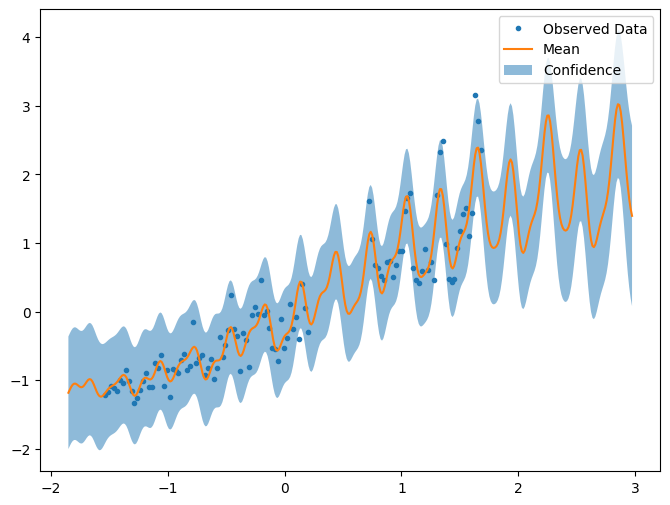

In [21]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
covar_module = gpytorch.kernels.PeriodicKernel() * gpytorch.kernels.RBFKernel()
model = ExactGPModel(train_x, train_y, likelihood, covar_module)
train_model(model, likelihood, train_x, train_y, training_iter=50)


model.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(test_x))

f = plot_model(observed_pred, train_x, train_y, test_x)

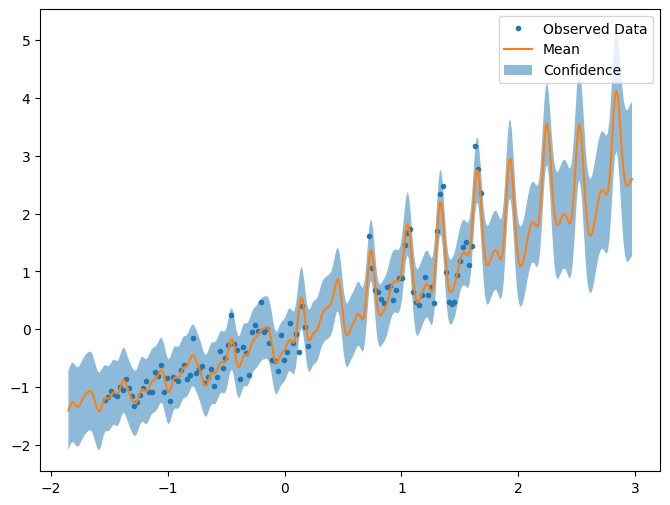

In [22]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
covar_module = gpytorch.kernels.ScaleKernel(
    gpytorch.kernels.PeriodicKernel() * gpytorch.kernels.RBFKernel()
)
covar_module += gpytorch.kernels.ScaleKernel(
    gpytorch.kernels.LinearKernel() * gpytorch.kernels.RBFKernel()
)
covar_module += gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

model = ExactGPModel(train_x, train_y, likelihood, covar_module)
train_model(model, likelihood, train_x, train_y, training_iter=50)


model.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(test_x))

f = plot_model(observed_pred, train_x, train_y, test_x)

/home/erlygin/miniconda/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/erlygin/miniconda/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/home/erlygin/miniconda/lib/python3.9/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(


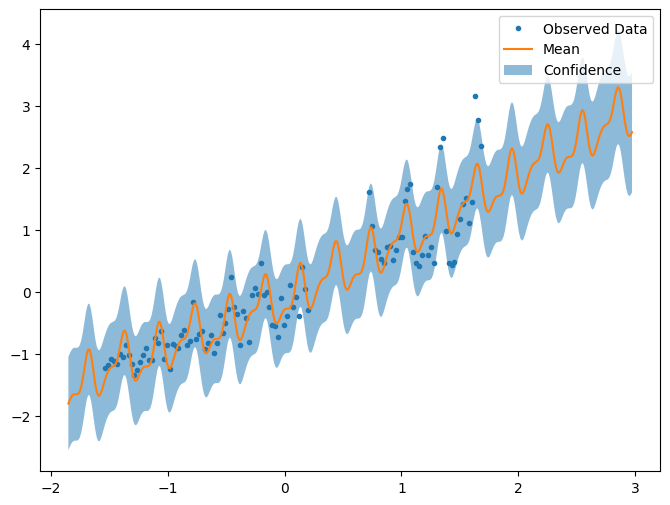

In [23]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.PeriodicKernel())
covar_module += gpytorch.kernels.ScaleKernel(gpytorch.kernels.LinearKernel())
covar_module += gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

model = ExactGPModel(train_x, train_y, likelihood, covar_module)
train_model(model, likelihood, train_x, train_y, training_iter=50)


model.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(test_x))

f = plot_model(observed_pred, train_x, train_y, test_x)